# **QUBO Model: Optimized Warehouse-to-Customer Assignment**

## **1. Overview**
This Quadratic Unconstrained Binary Optimization (QUBO) model is designed to optimize **warehouse-to-customer assignments** by minimizing transportation costs while ensuring that each customer is assigned to exactly one warehouse. The model incorporates **biasing** to prefer certain warehouse assignments and visualizes the optimized solution in a **distance-scaled network graph**.

---

## **2. Objective Function: Minimize Transportation Cost**
The primary objective of the model is to **minimize the total transport cost** based on the **distances between warehouses and customers**. This is achieved using the following cost function:

$$
\text{Cost} = \sum_{w=0}^{W-1} \sum_{c=0}^{C-1} d_{w,c} \cdot y_{w,c}
$$

Where:
- $ W $ = total number of warehouses  
- $ C $ = total number of customers  
- $ d_{w,c} $ = distance between warehouse $ w $ and customer $ c $  
- $ y_{w,c} $ is a **binary variable** that equals **1** if warehouse $ w $ serves customer $ c $, otherwise it is **0**.

The **solver aims to minimize this function**, which means it finds assignments that reduce the overall transportation cost.

---

## **3. Constraints: Each Customer Must Be Assigned to Exactly One Warehouse**
A key requirement in the model is that **each customer must be assigned to exactly one warehouse**. This is formulated as:

$$
\sum_{w=0}^{W-1} y_{w,c} = 1, \quad \forall c \in C
$$

This means that for each customer $ c $, the sum of all warehouse assignments must equal **1** (the customer cannot be left unassigned or assigned to multiple warehouses).  

To enforce this constraint in the QUBO model, we use a **quadratic penalty function**:

$$
P \cdot \left(\sum_{w=0}^{W-1} y_{w,c} - 1\right)^2
$$

Expanding this gives:

$$
P \sum_{w=0}^{W-1} y_{w,c}^2 - 2P \sum_{w=0}^{W-1} y_{w,c} + P
$$

Which is implemented in the model using:
- **Linear terms**: $ -2P \cdot y_{w,c} $  
- **Quadratic terms**: $ +2P \cdot y_{w1,c} \cdot y_{w2,c} $ for all warehouse pairs $ w1 \neq w2 $  
- **Offset term**: $ +P $, added once per customer  

This ensures that if a customer is assigned **more than one warehouse**, the penalty increases significantly, discouraging invalid assignments.

---

## **4. Bias Term: Preferential Warehouse Assignment**
To **bias** the assignment process towards a particular warehouse (e.g., `Warehouse #0`), a **negative linear term** is added for all $ y_{0,c} $ variables:

$$
B \sum_{c=0}^{C-1} y_{0,c}
$$

Where $ B $ is a negative bias value (e.g., $ B = -5 $). This **reduces the cost of assigning customers to Warehouse #0**, making it more likely to be selected when the solver optimizes the assignments.

---

## **5. Solving the QUBO Model**
The QUBO model is solved using **Simulated Annealing**, a probabilistic optimization algorithm designed for combinatorial problems. It iteratively refines candidate solutions to find a configuration that minimizes the total cost while satisfying constraints.

The solver produces a **binary assignment matrix**, where each $ y_{w,c} = 1 $ indicates an active warehouse-to-customer assignment.

---

## **6. Visualization: Scaled Warehouse-Customer Network**
The final assignment solution is visualized using **NetworkX**. The visualization includes:  
- **Red squares** (`W0, W1, ...`) representing **warehouses**  
- **Green circles** (`C0, C1, ...`) representing **customers**  
- **Edges (links)** connecting warehouses to customers  
  - **Blue edges**: Selected warehouse-customer assignments in the final optimized solution  
  - **Gray edges**: Possible assignments that were **not selected**  

To ensure that **distances are reflected accurately**, the visualization uses a **force-directed layout (`kamada_kawai_layout`)**, which arranges nodes so that:
- **Shorter distances** → **Closer nodes**  
- **Longer distances** → **Further apart nodes**  

This provides an **intuitive spatial representation** of warehouse-customer relationships based on the **actual numerical distances**.

---

## **7. Summary of Features**
✔ **Minimizes total transport costs** using a distance-based objective function  
✔ **Ensures each customer gets exactly one warehouse** using a penalty-based constraint  
✔ **Allows warehouse preference** through a **bias term**  
✔ **Solves using Simulated Annealing** to find the best assignments  
✔ **Visualizes the optimal solution** with a distance-scaled network graph  

---

## **8. Possible Extensions**
🔹 **Add Warehouse Capacity Constraints**: Prevent exceeding storage limits at each warehouse  
🔹 **Multi-Objective Optimization**: Introduce additional cost factors (e.g., priority customers)  
🔹 **Quantum Optimization**: Run the model on a quantum annealer (e.g., D-Wave) for faster performance  

This QUBO model provides a **strong foundation** for solving warehouse allocation problems and can be extended for larger, real-world supply chain applications. 🚀


In [ ]:
import numpy as np
import dimod
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler
import networkx as nx
import matplotlib.pyplot as plt

## 1. Generate Synthetic Data

In [8]:
np.random.seed(42)
num_warehouses = 3
num_customers = 4

# Random distances (costs)
distances = np.random.randint(10, 50, size=(num_warehouses, num_customers))
print('Distance Matrix:\n', distances)

Distance Matrix:
 [[48 38 24 17]
 [30 48 28 32]
 [20 20 33 45]]


## 2. Define Binary Variables: y[w,c] = 1 if warehouse w serves customer c

In [3]:
y = {(w,c): f'y_{w}_{c}' for w in range(num_warehouses) for c in range(num_customers)}

## 3. QUBO Model: Minimize Transport Cost

In [4]:
qubo = BinaryQuadraticModel.empty(vartype=dimod.BINARY)
for (w, c), var_name in y.items():
    qubo.add_linear(var_name, distances[w, c])

## 4. Add Bias (Favor Warehouse #0)


In [5]:
bias_for_warehouse_0 = -5
for c in range(num_customers):
    qubo.add_linear(y[(0, c)], bias_for_warehouse_0)


## 5. Constraint: Each Customer Assigned Exactly Once

In [6]:
penalty = 50
for c in range(num_customers):
    for w in range(num_warehouses):
        qubo.add_linear(y[(w, c)], -2*penalty)
    for w1 in range(num_warehouses):
        for w2 in range(w1+1, num_warehouses):
            qubo.add_quadratic(y[(w1, c)], y[(w2, c)], 2*penalty)
    qubo.offset += penalty

## 6. Solve the QUBO

In [7]:
sampler = SimulatedAnnealingSampler()
solution = sampler.sample(qubo, num_reads=1000)
best_sample = solution.first.sample
best_energy = solution.first.energy

print('\nBest Sample:', best_sample)
print('Best Energy:', best_energy)


Best Sample: {'y_0_0': np.int8(0), 'y_0_1': np.int8(0), 'y_0_2': np.int8(1), 'y_0_3': np.int8(1), 'y_1_0': np.int8(0), 'y_1_1': np.int8(0), 'y_1_2': np.int8(0), 'y_1_3': np.int8(0), 'y_2_0': np.int8(1), 'y_2_1': np.int8(1), 'y_2_2': np.int8(0), 'y_2_3': np.int8(0)}
Best Energy: -129.0


## 7. Interpret Results


In [9]:
selected_links = [(w, c) for (w, c), var_name in y.items() if best_sample[var_name] == 1]
print('Selected Warehouse-to-Customer Links:', selected_links)

Selected Warehouse-to-Customer Links: [(0, 2), (0, 3), (2, 0), (2, 1)]


## 8. Improved Visualization with Scaled Distances


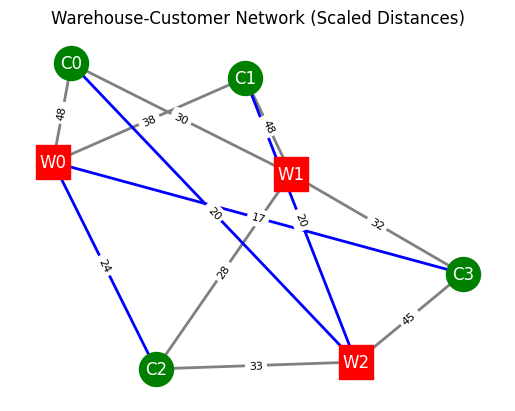

In [10]:
def visualize_with_scaled_distances(distances, selected_links):
    G = nx.Graph()

    # Add warehouse + customer nodes
    for w in range(num_warehouses):
        G.add_node(f'W{w}', bipartite=0)
    for c in range(num_customers):
        G.add_node(f'C{c}', bipartite=1)

    # Add edges with inverse distance as weight
    edge_weights = {}
    for w in range(num_warehouses):
        for c in range(num_customers):
            weight = 1 / distances[w, c]  # Shorter distance -> stronger connection
            G.add_edge(f'W{w}', f'C{c}', weight=weight, distance=distances[w, c])
            edge_weights[(f'W{w}', f'C{c}')] = weight

    # Use Kamada-Kawai layout to properly scale distances
    pos = nx.kamada_kawai_layout(G, weight='weight')

    # Draw all edges in light gray
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Color-code the selected edges in bold blue
    all_edges = list(G.edges())
    edge_colors = []
    for (n1, n2) in all_edges:
        if n1.startswith('W') and n2.startswith('C'):
            w_id, c_id = int(n1[1:]), int(n2[1:])
        else:
            w_id, c_id = int(n2[1:]), int(n1[1:])
        if (w_id, c_id) in selected_links:
            edge_colors.append('blue')
        else:
            edge_colors.append('gray')

    # Draw edges again with colored highlights
    nx.draw_networkx_edges(G, pos, edgelist=all_edges, edge_color=edge_colors, width=2)

    # Draw nodes
    warehouse_nodes = [f'W{w}' for w in range(num_warehouses)]
    customer_nodes = [f'C{c}' for c in range(num_customers)]

    nx.draw_networkx_nodes(G, pos, nodelist=warehouse_nodes, node_color='red', node_shape='s', node_size=600)
    nx.draw_networkx_nodes(G, pos, nodelist=customer_nodes, node_color='green', node_shape='o', node_size=600)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_color='white')

    # Edge labels for distances
    edge_labels = {(u, v): f"{d['distance']}" for (u, v, d) in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=8)

    plt.title('Warehouse-Customer Network (Scaled Distances)')
    plt.axis('off')
    plt.show()

visualize_with_scaled_distances(distances, selected_links)